In [58]:
!pip install BisPy
!pip install ogb
!pip install torch-geometric

In [59]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import pandas as pd
from torch_geometric.datasets import Planetoid, CoraFull, Yelp, WebKB, Actor
import os
import bispy
from bispy import compute_maximum_bisimulation, Algorithms
from bispy.dovier_piazza_policriti.dovier_piazza_policriti import dovier_piazza_policriti_partition
from bispy.dovier_piazza_policriti.ranked_partition import RankedPartition
from bispy.dovier_piazza_policriti.dovier_piazza_policriti import dovier_piazza_policriti, collapse, build_block_counterimage, split_upper_ranks
from bispy.utilities.rank_computation import compute_rank
from bispy.utilities.graph_decorator import decorate_nx_graph, decorate_bispy_graph,as_bispy_graph,to_tuple_list
from bispy.utilities import *
import numpy as np
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [60]:
# Create an empty NetworkX graph
from torch_geometric.utils import from_networkx
G = nx.DiGraph()
node_map = {}

def get_key(val, node_map):
    for key, value in node_map.items():
        if val == value:
            return key
    return "key doesn't exist"


# Driver Code
# my_dict = {"Java": 100, "Python": 112, "C": 11}

# print(get_key(100))
# print(get_key(11))

# Read node features and labels from 'cora.content'
with open('/content/gdrive/My Drive/GNN_Sparsification/Algorithms/cora.content', 'r') as content_file:
    i = 0
    for line in content_file:
        data = line.strip().split('\t')
        node_id = data[0]
        features = [float(x) for x in data[1:-1]]
        label = data[-1]
        node_map[i] = node_id
        # print(node_id)
        # Add node to the graph with features and label
        G.add_node(i, features=features, label=label)
        i+=1

# Read edges from 'cora.cites'
with open('/content/gdrive/My Drive/GNN_Sparsification/Algorithms/cora.cites', 'r') as cites_file:
    for line in cites_file:
        source, target = line.strip().split('\t')
        source = get_key(source, node_map)
        target = get_key(target, node_map)
        G.add_edge(source, target)




data_path = '/content/gdrive/MyDrive/GNN_Sparsification/Algorithms/cora.content'  # Update with the correct path
# column_names = ["paper_id"] + [f"attr_{i}" for i in range(1433)] + ["subject"]
column_names = [f"attr_{i}" for i in range(1433)] + ["subject"]
df = pd.read_csv(data_path, sep='\t', header=None, names=column_names)

# Display the first few rows
df = df.iloc[:,1:-1]

# Access a specific attribute for a specific node
# attribute_values_for_node_0 = df.loc[0, "attr_0":"attr_1432"]

# Access the subject label for a specific node
# subject_label_for_node_0 = df.loc[0, "subject"]
# Print basic graph information
data = from_networkx(G)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 2708
Number of edges: 5429


In [61]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [62]:
# Cora
from torch_geometric.datasets import Planetoid, CoraFull, Yelp, WebKB

dataset = Planetoid(root='/tmp/Cora', name='Cora')
# dataset = Yelp(root='Yelp')
cora = dataset[0]
cora.y = torch.squeeze(cora.y)
cora

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [63]:
cora.edge_index = data.edge_index
cora

Data(x=[2708, 1433], edge_index=[2, 5429], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [64]:
# Load tensor from .pt file
#loaded_tensor = torch.load('ARXIV_SPAR.pt')
#data.edge_index = loaded_tensor.edge_index

In [65]:
data

Data(edge_index=[2, 5429], features=[2708, 1433], label=[2708], num_nodes=2708)

In [66]:
import copy
from torch_geometric.utils import subgraph
train_mask = torch.rand(data.num_nodes) < 0.8
test_mask = ~train_mask
tested_elements =  torch.nonzero(test_mask==True).squeeze()
tested_elements = tested_elements.tolist()

In [67]:
file_path = "/content/drive/MyDrive/GNN_Sparsification/20%_cora_train_mask.pt"

# Save the binary tensor mask to a .pt file
torch.save(train_mask, file_path)

In [68]:
train_mask = torch.load("/content/drive/MyDrive/GNN_Sparsification/20%_cora_train_mask.pt")
test_mask = ~train_mask
tested_elements =  torch.nonzero(test_mask==True).squeeze()
tested_elements = tested_elements.tolist()

In [69]:
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx


# Convert PyG graph to NetworkX graph
def pyg_to_networkx(pyg_data):
    edge_index = pyg_data.edge_index
    num_nodes = pyg_data.num_nodes
    edge_list = edge_index.t().tolist()
    G = nx.DiGraph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(edge_list)
    return G

networkx_graph = pyg_to_networkx(cora)

# Radius-based K-hops Induced Subgraph

In [70]:
nodes_to_find_neighbors = tested_elements
neighbors = set()
up_to_k_hop_neighbors = []
up_to_k_hop_neighbors_list = []
k = 1
# G = nx.Graph()
G = nx.DiGraph()

for i in range(k):
  # Iterate through the nodes in your set
  print(i)
  neighbors = set()
  for node in nodes_to_find_neighbors:
    # Use the neighbors() function to get 1-hop neighbors and add them to the set
    neighbors.update(networkx_graph.neighbors(node))
    neighbors.update(networkx_graph.predecessors(node))

    if i == 0:
      G.add_node(node)

      for neighbor in networkx_graph.neighbors(node):
        if neighbor not in nodes_to_find_neighbors:
          G.add_edge(node, neighbor)

      for neighbor in networkx_graph.predecessors(node):
        if neighbor not in nodes_to_find_neighbors:
          G.add_edge(neighbor, node)


    else:
      for neighbor in networkx_graph.neighbors(node):
        if neighbor not in up_to_k_hop_neighbors_list:
          G.add_edge(node, neighbor)

      for neighbor in networkx_graph.predecessors(node):
        if neighbor not in up_to_k_hop_neighbors_list:
          G.add_edge(neighbor, node)




  # ensure the disjoint property
  if i > 0:
    for ele in up_to_k_hop_neighbors:
      neighbors_list = list(set(list(neighbors)).difference(set(ele)))
    neighbors_list = list(set(neighbors).difference(set(tested_elements)))

  if i == 0:
    neighbors_list = list(set(neighbors).difference(set(tested_elements)))
    up_to_k_hop_neighbors_list += tested_elements

  nodes_to_find_neighbors = neighbors_list
  up_to_k_hop_neighbors.append(neighbors_list)
  up_to_k_hop_neighbors_list += neighbors_list

0


# Diameter-based K-hops Induced Subgraph

In [71]:
nodes_to_find_neighbors = tested_elements
neighbors = set()
up_to_k_hop_neighbors = []
up_to_k_hop_neighbors_list = []
k = 1
# G = nx.Graph()
G = nx.DiGraph()

for i in range(k):
  # Iterate through the nodes in your set
  print(i)
  neighbors = set()
  for node in nodes_to_find_neighbors:
    # Use the neighbors() function to get 1-hop neighbors and add them to the set
    neighbors.update(networkx_graph.predecessors(node))

    if i == 0:
      G.add_node(node)

      for neighbor in networkx_graph.predecessors(node):
        if neighbor not in nodes_to_find_neighbors:
          G.add_edge(neighbor, node)


    else:
      for neighbor in networkx_graph.predecessors(node):
        # if neighbor not in up_to_k_hop_neighbors_list:
        if neighbor not in nodes_to_find_neighbors:
          G.add_edge(neighbor, node)




  # ensure the disjoint property
  if i > 0:
    for ele in up_to_k_hop_neighbors:
      neighbors_list = list(set(list(neighbors)).difference(set(ele)))
    neighbors_list = list(set(neighbors).difference(set(tested_elements)))

  if i == 0:
    neighbors_list = list(set(neighbors).difference(set(tested_elements)))
    up_to_k_hop_neighbors_list += tested_elements

  nodes_to_find_neighbors = neighbors_list
  up_to_k_hop_neighbors.append(neighbors_list)
  up_to_k_hop_neighbors_list += neighbors_list

0


In [72]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)


partition = compute_maximum_bisimulation(G)
len(partition)

Number of nodes: 1071
Number of edges: 858


2

In [73]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

import time

# Measure the execution time
start_time = time.time()

partition = compute_maximum_bisimulation(G)
len(partition)

end_time = time.time()
execution_time = end_time - start_time



print(f"Execution time: {execution_time} seconds")

Number of nodes: 1071
Number of edges: 858
Execution time: 0.03502845764160156 seconds


In [74]:
cora

Data(x=[2708, 1433], edge_index=[2, 5429], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [75]:
#cora_FGC = torch.load('gdrive/My Drive/GNN_Sparsification/Coarsened_CORA.pt')
#cora_FGC

In [76]:
#edge_indices

In [77]:
#cora_FGC.edge_index = edge_indices
#cora_FGC

In [78]:
#torch.save(cora_FGC,'gdrive/My Drive/GNN_Sparsification/cora_FGC.pt')

In [79]:
tuple_list = partition
def find_tuple_index_with_integer(list_of_tuples, integer):
    return next((index for index, tup in enumerate(list_of_tuples) if integer in tup), -1)

# Sort the list by the number of elements in each tuple
sorted_list = sorted(tuple_list, key=lambda x: len(x), reverse=True)

indices = []
list_of_lists = [list(t) for t in sorted_list]

for ele in tested_elements:
  id = find_tuple_index_with_integer(sorted_list, ele)
  if len(list_of_lists[id]) > 1:
    list_of_lists[id].remove(ele)
    list_of_lists.append([ele])
    indices.append(len(list_of_lists)-1)
  else:
    indices.append(id)

list_of_tuples = [tuple(inner_list) for inner_list in list_of_lists]

In [80]:
i = 0
while len(list_of_lists[i])>1:
    # print(i)

    Z = linkage(data.x[list_of_tuples[i],:], method='average', metric='cosine')
    threshold = 0.6 * np.max(Z[:, 2])
    clusters = fcluster(Z, threshold, criterion='distance')

    # Get cluster labels for each data point
    labels = clusters

    # Sample tuple to split
    data_tuple = list_of_tuples[i]

    # Create a dictionary to store split data
    split_data = {}

    # Iterate through the labels and tuple elements
    for label, value in zip(labels, data_tuple):
      if label not in split_data:
        split_data[label] = []
      split_data[label].append(value)

    # Convert the dictionary to a list of tuples (if needed)
    split_tuples = [tuple(values) for key, values in split_data.items()]
    list_of_tuples.pop(i)
    j = 0
    for values in split_tuples:
      if j == 0:
        list_of_tuples.insert(0, values)
      else:
        list_of_tuples.insert(len(list_of_tuples), values)
      j+=1

    i+=1

result_dict = {element: index for index, tup in enumerate(list_of_tuples) for element in tup}

# Alpha = 0.1


In [81]:
BCG = nx.DiGraph()
import random

for i in range(len(list_of_tuples)):
  BCG.add_node(i)

for edge in G.edges():
    source, target = edge
    BCG.add_edge(result_dict[source], result_dict[target])

# Get the number of nodes and edges
num_nodes = BCG.number_of_nodes()
num_edges = BCG.number_of_edges()

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 581
Number of edges: 416


# Alpha = 0.2

In [82]:
BCG = nx.DiGraph()
import random

for i in range(len(list_of_tuples)):
  BCG.add_node(i)

for edge in G.edges():
    source, target = edge
    BCG.add_edge(result_dict[source], result_dict[target])

# Get the number of nodes and edges
num_nodes = BCG.number_of_nodes()
num_edges = BCG.number_of_edges()

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 581
Number of edges: 416


# Alpha = 0.3

In [83]:
BCG = nx.DiGraph()
import random

for i in range(len(list_of_tuples)):
  BCG.add_node(i)

for edge in G.edges():
    source, target = edge
    BCG.add_edge(result_dict[source], result_dict[target])

# Get the number of nodes and edges
num_nodes = BCG.number_of_nodes()
num_edges = BCG.number_of_edges()

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 581
Number of edges: 416


# 0.4

In [84]:
BCG = nx.DiGraph()
import random

for i in range(len(list_of_tuples)):
  BCG.add_node(i)

for edge in G.edges():
    source, target = edge
    BCG.add_edge(result_dict[source], result_dict[target])

# Get the number of nodes and edges
num_nodes = BCG.number_of_nodes()
num_edges = BCG.number_of_edges()

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 581
Number of edges: 416


# 0.5

In [85]:
BCG = nx.DiGraph()
import random

for i in range(len(list_of_tuples)):
  BCG.add_node(i)

for edge in G.edges():
    source, target = edge
    BCG.add_edge(result_dict[source], result_dict[target])

# Get the number of nodes and edges
num_nodes = BCG.number_of_nodes()
num_edges = BCG.number_of_edges()

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 581
Number of edges: 416


# 1

In [86]:
result_dict = {element: index for index, tup in enumerate(list_of_tuples) for element in tup}

BCG = nx.DiGraph()
import random

for i in range(len(list_of_tuples)):
  BCG.add_node(i)

for edge in G.edges():
    source, target = edge
    BCG.add_edge(result_dict[source], result_dict[target])

# Get the number of nodes and edges
num_nodes = BCG.number_of_nodes()
num_edges = BCG.number_of_edges()

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 581
Number of edges: 416


In [87]:
from collections import Counter
import random

new_x = torch.zeros(num_nodes,cora.x.shape[1])
new_y = torch.zeros(num_nodes)
for i in range(len(list_of_tuples)):
  new_x[i,:] = torch.mean(cora.x[list(list_of_tuples[i]),:], axis = 0)
  EC = list_of_tuples[i]
  L = []
  for ele in EC:
    L.append(int(cora.y[ele].numpy()))

  keys = list(Counter(L).keys())
  frequencies = list(Counter(L).values())

  # Randomly select a key based on frequencies
  random_key = random.choices(keys, frequencies)[0]
  new_y[i] = int(random_key)

edges = list(BCG.edges())

# Create a dictionary to map node labels to integer indices
node_mapping = {node: index for index, node in enumerate(BCG.nodes())}

# Convert the edges to indices using the node_mapping
new_edge_index = [[node_mapping[source], node_mapping[target]] for source, target in edges]
new_edge_index = torch.tensor(new_edge_index, dtype=torch.long).t().contiguous()

data_new1 = copy.copy(data)
data_new1.x = new_x
data_new1.y = new_y.long()
data_new1.edge_index = new_edge_index
data_new1.num_nodes = len(new_y)

In [88]:
data

Data(edge_index=[2, 5429], features=[2708, 1433], label=[2708], num_nodes=2708)

In [89]:
data.y = cora.y

In [90]:
from collections import Counter
import random
import copy
from collections import Counter

new_x = torch.zeros(len(list(G.nodes)),cora.x.shape[1])
new_y = torch.zeros(len(list(G.nodes)))
list_itr = list(G.nodes)
for i in range(len(list(G.nodes))):
  new_x[i,:] = cora.x[list_itr[i],:]
  new_y[i] = int(cora.y[list_itr[i]])

edges = list(G.edges())

# Create a dictionary to map node labels to integer indices
node_mapping = {node: index for index, node in enumerate(G.nodes())}

# Convert the edges to indices using the node_mapping
new_edge_index = [[node_mapping[source], node_mapping[target]] for source, target in edges]
new_edge_index = torch.tensor(new_edge_index, dtype=torch.long).t().contiguous()


data_new1 = copy.copy(data)
data_new1.x = new_x
data_new1.y = new_y.long()
data_new1.edge_index = new_edge_index
data_new1.num_nodes = len(new_y)

In [91]:
torch.save(data_new1, '/content/drive/My Drive/GNN_Sparsification/20%_Induced_cora.pt')

In [92]:
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np

def exclude_tested_elements_from_MB(partition, tested_elements):
    tuple_dict = {}
    indices = []

    tuple_list = partition

    # Sort the list by the number of elements in each tuple
    sorted_list = sorted(tuple_list, key=lambda x: len(x), reverse=True)

    list_of_lists = [list(t) for t in sorted_list]

    # Convert tuples to lists and create a dictionary with elements as keys and their corresponding tuple index as values
    for idx, tpl in enumerate(list_of_lists):
        tpl_list = list(tpl)
        for ele in tpl_list:
            tuple_dict[ele] = idx
        list_of_lists[idx] = tpl_list

    # Update the dictionary and indices based on tested elements
    for ele in tested_elements:
        if ele in tuple_dict:
            idx = tuple_dict[ele]
            if len(list_of_lists[idx]) > 1:
                list_of_lists[idx].remove(ele)
                list_of_lists.append([ele])
                tuple_dict[ele] = len(list_of_lists) - 1
                indices.append(len(list_of_lists) - 1)
            else:
                indices.append(idx)

    return list_of_lists, indices

def alpha_Sparsification(list_of_lists, data, alpha):
  list_of_tuples = [tuple(inner_list) for inner_list in list_of_lists]
  i = 0
  while len(list_of_lists[i])>1:

      Z = linkage(data.x[list_of_tuples[i],:].detach().numpy(), method='average', metric='cosine')
      threshold = alpha * np.max(Z[:, 2])
      clusters = fcluster(Z, threshold, criterion='distance')

      # Get cluster labels for each data point
      labels = clusters


      # Z = linkage(data.x[list_of_tuples[i],:], method='average', metric='euclidean')
      # threshold = alpha * np.max(Z[:, 2])
      # clusters = fcluster(Z, threshold, criterion='distance')

      # # Get cluster labels for each data point
      # labels = clusters




      # Sample tuple to split
      data_tuple = list_of_tuples[i]

      # Create a dictionary to store split data
      split_data = {}

      # Iterate through the labels and tuple elements
      for label, value in zip(labels, data_tuple):
        if label not in split_data:
          split_data[label] = []
        split_data[label].append(value)

      # Convert the dictionary to a list of tuples (if needed)
      split_tuples = [tuple(values) for key, values in split_data.items()]
      list_of_tuples.pop(i)
      j = 0
      for values in split_tuples:
        if j == 0:
          list_of_tuples.insert(0, values)
        else:
          list_of_tuples.insert(len(list_of_tuples), values)
        j+=1

      i+=1

  result_dict = {element: index for index, tup in enumerate(list_of_tuples) for element in tup}

  return list_of_tuples, result_dict

# def alpha_Sparsification(list_of_lists, data, alpha):
#     list_of_tuples = [tuple(inner_list) for inner_list in list_of_lists]
#     i = 0
#     while i<len(list_of_lists):
#         if len(list_of_lists[i])>1:
#             Z = linkage(data.x[list_of_tuples[i],:], method='average', metric='cosine')
#             threshold = alpha * np.max(Z[:, 2])
#             clusters = fcluster(Z, threshold, criterion='distance')
#             # Get cluster labels for each data point
#             labels = clusters
#             # Sample tuple to split
#             data_tuple = list_of_tuples[i]
#             # Create a dictionary to store split data
#             split_data = {}
#           # Iterate through the labels and tuple elements
#             for label, value in zip(labels, data_tuple):
#                 if label not in split_data:
#                     split_data[label] = []
#                 split_data[label].append(value)

#           # Convert the dictionary to a list of tuples (if needed)
#             split_tuples = [tuple(values) for key, values in split_data.items()]
#             list_of_tuples.pop(i)
#             j = 0
#             for values in split_tuples:
#                 if j == 0:
#                     list_of_tuples.insert(0, values)
#                 else:
#                     list_of_tuples.insert(len(list_of_tuples), values)
#                 j+=1

#         i+=1

#     result_dict = {element: index for index, tup in enumerate(list_of_tuples) for element in tup}
#     return list_of_tuples, result_dict

In [93]:
def Sparisified_G_NX(list_of_tuples, result_dict, data):
  BCG = nx.DiGraph()

  for i in range(len(list_of_tuples)):
    BCG.add_node(i)

  for edge in G.edges():
      source, target = edge
      # if cosine_similarity(data.x[source].numpy().reshape(1, -1), data.x[target].numpy().reshape(1, -1)) > 0.5:
      BCG.add_edge(result_dict[source], result_dict[target])

  num_nodes = BCG.number_of_nodes()
  num_edges = BCG.number_of_edges()



  print("Number of nodes:", num_nodes)
  print("Number of edges:", num_edges)


  return BCG

In [94]:
from torch_geometric.data import Data

def Sparisified_G_Alpha(BCG, data, list_of_tuples):
  num_nodes = BCG.number_of_nodes()
  new_x = torch.zeros(num_nodes,data.x.shape[1])
  new_y = torch.zeros(num_nodes)
  for i in range(len(list_of_tuples)):
    new_x[i,:] = torch.mean(data.x[list(list_of_tuples[i]),:], axis = 0)
    # new_x[i,:] = torch.sum(data.x[list(list_of_tuples[i]),:], axis = 0)
    # new_x[i, :] = torch.tensor(np.median(data.x[list(list_of_tuples[i]), :], axis=0))
    # new_x[i, :] = torch.max(data.x[list(list_of_tuples[i]), :], axis=0).values
    # new_x[i, :] = torch.min(data.x[list(list_of_tuples[i]), :], axis=0).values


    EC = list_of_tuples[i]
    L = []
    for ele in EC:
      L.append(int(data.y[ele].numpy()))

    keys = list(Counter(L).keys())
    frequencies = list(Counter(L).values())

    # Randomly select a key based on frequencies
    random_key = random.choices(keys, frequencies)[0]
    new_y[i] = int(random_key)

  print("Completed_Flag")
  edges = list(BCG.edges())

  # Create a dictionary to map node labels to integer indices
  node_mapping = {node: index for index, node in enumerate(BCG.nodes())}

  # Convert the edges to indices using the node_mapping
  new_edge_index = [[node_mapping[source], node_mapping[target]] for source, target in edges]
  new_edge_index = torch.tensor(new_edge_index, dtype=torch.long).t().contiguous()

  data_new1 = Data()
  data_new1.x = new_x
  data_new1.y = new_y.long()
  data_new1.edge_index = new_edge_index
  data_new1.num_nodes = len(new_y)

  return data_new1

In [95]:
def Sparisified_G_Alpha_0(G, data):

  new_x = torch.zeros(len(list(G.nodes)),data.x.shape[1])
  new_y = torch.zeros(len(list(G.nodes)))
  list_itr = list(G.nodes)
  for i in range(len(list(G.nodes))):
    new_x[i,:] = data.x[list_itr[i],:]
    new_y[i] = int(data.y[list_itr[i]])

  edges = list(G.edges())

  # Create a dictionary to map node labels to integer indices
  node_mapping = {node: index for index, node in enumerate(G.nodes())}

  # Convert the edges to indices using the node_mapping
  new_edge_index = [[node_mapping[source], node_mapping[target]] for source, target in edges]
  new_edge_index = torch.tensor(new_edge_index, dtype=torch.long).t().contiguous()


  data_new1 = Data()
  data_new1.x = new_x
  data_new1.y = new_y.long()
  data_new1.edge_index = new_edge_index
  data_new1.num_nodes = len(new_y)

  return data_new1

In [96]:
import copy
from collections import Counter
alpha_list = [0, 0.1, 1]

for alpha in alpha_list:
  # print(alpha)
  if alpha == 0:
    start_time = time.time()
    data_new_1 = Sparisified_G_Alpha_0(G, cora)
    end_time = time.time()
    execution_time_SPGS = end_time - start_time
    print(f"Execution time: {execution_time_SPGS} seconds")

    tested_elements_set = set(tested_elements)
    indices = [index for index, node in enumerate(G.nodes) if node in tested_elements_set]


  if alpha > 0 and alpha < 1:
    print(alpha)
    if alpha == alpha_list[1]:
      start_time_1 = time.time()
      list_of_lists, indices = exclude_tested_elements_from_MB(partition, tested_elements)


    list_of_tuples, result_dict = alpha_Sparsification(list_of_lists, cora, alpha)
    # end_time_1 = time.time()
    # execution_time_1 = end_time_1 - start_time_1
    # print(f"Execution time of alpha_Sparsification: {execution_time_1} seconds")

    BCG = Sparisified_G_NX(list_of_tuples, result_dict, cora)
    data_new_1 = Sparisified_G_Alpha(BCG, cora, list_of_tuples)
    end_time_2 = time.time()
    execution_time_2 = end_time_2 - start_time_1
    print(f"Execution time of  (alpha, r) SPGC: {execution_time_2} seconds")

  if alpha == 1:
    l_o_t = [tuple(inner_list) for inner_list in list_of_lists]
    r_d = {element: index for index, tup in enumerate(list_of_tuples) for element in tup}
    start_time_3 = time.time()
    BCG = Sparisified_G_NX(l_o_t, r_d, cora)
    data_new_1 = Sparisified_G_Alpha(BCG, cora, l_o_t)
    end_time_3 = time.time()
    execution_time_3 = end_time_3 - start_time_3
    print(f"Execution time of SPGC: {execution_time_3} seconds")

Execution time: 0.1646888256072998 seconds
0.1
Number of nodes: 581
Number of edges: 416
Completed_Flag
Execution time of  (alpha, r) SPGC: 0.2444899082183838 seconds
Number of nodes: 581
Number of edges: 416
Completed_Flag
Execution time of SPGC: 0.1902916431427002 seconds


In [97]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [98]:
# from torch_geometric.nn import GATConv, GCNConv, GraphSAGE, BatchNorm
# import torch

# class GCN(torch.nn.Module):
#   def __init__(self):
#     super().__init__()

#     self.conv1 = GCNConv(dataset.num_node_features, 128,aggr = 'mean')
#     self.bc1 = BatchNorm(128)
#     self.conv2 = GCNConv(128, 128,aggr = 'mean')
#     self.bc2 = BatchNorm(128)
#     self.conv3 = GCNConv(128, dataset.num_classes,aggr = 'mean')
#     self.bc3 = BatchNorm(dataset.num_classes)
#   def forward(self, x, edge_index):
#     # x: Node feature matrix
#     # edge_index: Graph connectivity matrix
#     x = self.conv1(x, edge_index)
#     x = torch.nn.functional.relu(x)
#     x = self.bc1(x)
#     x = self.conv2(x, edge_index)
#     x = torch.nn.functional.relu(x)
#     x = self.bc2(x)
#     x = self.conv3(x, edge_index)
#     x = torch.nn.functional.relu(x)
#     x = self.bc3(x)
#     return torch.nn.functional.log_softmax(x, dim=1)

# model = GCN()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# print("Graph Convolutional Network (GCN):")
# GCN()

# 4-layer GCN

In [99]:
from torch_geometric.nn import GATConv, GCNConv, GraphSAGE, BatchNorm
import torch

class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = GCNConv(dataset.num_node_features, 128)
    self.bc1 = BatchNorm(128)
    self.conv2 = GCNConv(128, 128)
    self.bc2 = BatchNorm(128)
    self.conv3 = GCNConv(128, 128)
    self.bc3 = BatchNorm(128)
    self.conv4 = GCNConv(128, dataset.num_classes)
    self.bc4 = BatchNorm(dataset.num_classes)
    # self.dropout = Dropout(p=0.5)
  def forward(self, x, edge_index):
    # x: Node feature matrix
    # edge_index: Graph connectivity matrix
    x = self.conv1(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc1(x)
    x = self.conv2(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc2(x)
    x = self.conv3(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc3(x)
    x = self.conv4(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc4(x)

    return torch.nn.functional.log_softmax(x, dim=1)

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print("Graph Convolutional Network (GCN):")
GCN()

Graph Convolutional Network (GCN):


GCN(
  (conv1): GCNConv(1433, 128)
  (bc1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(128, 128)
  (bc2): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(128, 128)
  (bc3): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): GCNConv(128, 7)
  (bc4): BatchNorm(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# 3 Layer GCN

In [100]:
from torch_geometric.nn import GATConv, GCNConv, GraphSAGE, BatchNorm
import torch

class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = GCNConv(dataset.num_node_features, 128)
    self.bc1 = BatchNorm(128)
    self.conv2 = GCNConv(128, 128)
    self.bc2 = BatchNorm(128)
    self.conv3 = GCNConv(128, dataset.num_classes)
    self.bc3 = BatchNorm(dataset.num_classes)
    # self.dropout = Dropout(p=0.5)
  def forward(self, x, edge_index):
    # x: Node feature matrix
    # edge_index: Graph connectivity matrix
    x = self.conv1(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc1(x)
    # x = self.dropout(x)
    x = self.conv2(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc2(x)
    # x = self.dropout(x)
    x = self.conv3(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc3(x)
    return torch.nn.functional.log_softmax(x, dim=1)

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print("Graph Convolutional Network (GCN):")
GCN()

Graph Convolutional Network (GCN):


GCN(
  (conv1): GCNConv(1433, 128)
  (bc1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(128, 128)
  (bc2): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GCNConv(128, 7)
  (bc3): BatchNorm(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# 2-layer GCN

In [101]:
from torch_geometric.nn import GATConv, GCNConv, GraphSAGE, BatchNorm
import torch

class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = GCNConv(dataset.num_node_features, 128)
    self.bc1 = BatchNorm(128)
    self.conv2 = GCNConv(128, 7)
    self.bc2 = BatchNorm(dataset.num_classes)

  def forward(self, x, edge_index):
    # x: Node feature matrix
    # edge_index: Graph connectivity matrix
    x = self.conv1(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc1(x)
    x = self.conv2(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc2(x)

    return torch.nn.functional.log_softmax(x, dim=1)

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print("Graph Convolutional Network (GCN):")
GCN()

Graph Convolutional Network (GCN):


GCN(
  (conv1): GCNConv(1433, 128)
  (bc1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GCNConv(128, 7)
  (bc2): BatchNorm(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# 4-layer GAT

In [102]:
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
import torch

class GAT(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = GATConv(dataset.num_node_features, 128)
    self.bc1 = BatchNorm(128)
    self.conv2 = GATConv(128, 128)
    self.bc2 = BatchNorm(128)
    self.conv3 = GATConv(128, 128)
    self.bc3 = BatchNorm(128)
    self.conv4 = GATConv(128, dataset.num_classes)
    self.bc4 = BatchNorm(dataset.num_classes)

  def forward(self, x, edge_index):
    # x: Node feature matrix
    # edge_index: Graph connectivity matrix
    x = self.conv1(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc1(x)
    # x = self.dropout(x)
    x = self.conv2(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc2(x)
    # x = self.dropout(x)
    x = self.conv3(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc3(x)
    x = self.conv4(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc4(x)

    return torch.nn.functional.log_softmax(x, dim=1)

model = GAT()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print("GAT:")
GAT()

GAT:


GAT(
  (conv1): GATConv(1433, 128, heads=1)
  (bc1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(128, 128, heads=1)
  (bc2): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GATConv(128, 128, heads=1)
  (bc3): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): GATConv(128, 7, heads=1)
  (bc4): BatchNorm(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# 3-layer GAT

In [103]:
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
import torch

class GAT(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = GATConv(dataset.num_node_features, 128)
    self.bc1 = BatchNorm(128)
    self.conv2 = GATConv(128, 128)
    self.bc2 = BatchNorm(128)
    self.conv3 = GATConv(128, dataset.num_classes)
    self.bc3 = BatchNorm(dataset.num_classes)
    # self.dropout = Dropout(p=0.5)

  def forward(self, x, edge_index):
    # x: Node feature matrix
    # edge_index: Graph connectivity matrix
    x = self.conv1(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc1(x)
    # x = self.dropout(x)
    x = self.conv2(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc2(x)
    # x = self.dropout(x)
    x = self.conv3(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc3(x)
    return torch.nn.functional.log_softmax(x, dim=1)

model = GAT()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print("GAT:")
GAT()

GAT:


GAT(
  (conv1): GATConv(1433, 128, heads=1)
  (bc1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(128, 128, heads=1)
  (bc2): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GATConv(128, 7, heads=1)
  (bc3): BatchNorm(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# 2-layer GAT

In [104]:
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
import torch

class GAT(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = GATConv(dataset.num_node_features, 128)
    self.bc1 = BatchNorm(128)
    self.conv2 = GATConv(128, 7)
    self.bc2 = BatchNorm(dataset.num_classes)

  def forward(self, x, edge_index):
    # x: Node feature matrix
    # edge_index: Graph connectivity matrix
    x = self.conv1(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc1(x)
    # x = self.dropout(x)
    x = self.conv2(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc2(x)
    return torch.nn.functional.log_softmax(x, dim=1)

model = GAT()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print("GAT:")
GAT()

GAT:


GAT(
  (conv1): GATConv(1433, 128, heads=1)
  (bc1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(128, 7, heads=1)
  (bc2): BatchNorm(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# 4-layer SAGE

In [105]:
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
import torch
from torch.nn import Module, Dropout

class GraphSAGE(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = SAGEConv(dataset.num_node_features, 128)
    self.bc1 = BatchNorm(128)
    self.conv2 = SAGEConv(128, 128)
    self.bc2 = BatchNorm(128)
    self.conv3 = SAGEConv(128, 128)
    self.bc3 = BatchNorm(128)
    self.conv4 = SAGEConv(128, dataset.num_classes)
    self.bc4 = BatchNorm(dataset.num_classes)
    # self.dropout = Dropout(p=0.5)

  def forward(self, x, edge_index):
    # x: Node feature matrix
    # edge_index: Graph connectivity matrix
    x = self.conv1(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc1(x)
    # x = self.dropout(x)
    x = self.conv2(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc2(x)
    # x = self.dropout(x)
    x = self.conv3(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc3(x)
    x = self.conv4(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc4(x)

    return torch.nn.functional.log_softmax(x, dim=1)

model = GraphSAGE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print("GraphSAGE:")
GraphSAGE()

GraphSAGE:


GraphSAGE(
  (conv1): SAGEConv(1433, 128, aggr=mean)
  (bc1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): SAGEConv(128, 128, aggr=mean)
  (bc2): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): SAGEConv(128, 128, aggr=mean)
  (bc3): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): SAGEConv(128, 7, aggr=mean)
  (bc4): BatchNorm(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# 3-layer SAGE

In [106]:
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
import torch
from torch.nn import Module, Dropout

class GraphSAGE(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = SAGEConv(dataset.num_node_features, 128)
    self.bc1 = BatchNorm(128)
    self.conv2 = SAGEConv(128, 128)
    self.bc2 = BatchNorm(128)
    self.conv3 = SAGEConv(128, dataset.num_classes)
    self.bc3 = BatchNorm(dataset.num_classes)
    # self.dropout = Dropout(p=0.5)

  def forward(self, x, edge_index):
    # x: Node feature matrix
    # edge_index: Graph connectivity matrix
    x = self.conv1(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc1(x)
    # x = self.dropout(x)
    x = self.conv2(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc2(x)
    # x = self.dropout(x)
    x = self.conv3(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc3(x)
    return torch.nn.functional.log_softmax(x, dim=1)

model = GraphSAGE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print("GraphSAGE:")
GraphSAGE()

GraphSAGE:


GraphSAGE(
  (conv1): SAGEConv(1433, 128, aggr=mean)
  (bc1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): SAGEConv(128, 128, aggr=mean)
  (bc2): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): SAGEConv(128, 7, aggr=mean)
  (bc3): BatchNorm(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

# 2-layer SAGE

In [107]:
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
import torch
from torch.nn import Module, Dropout

class GraphSAGE(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = SAGEConv(dataset.num_node_features, 128)
    self.bc1 = BatchNorm(128)
    self.conv2 = SAGEConv(128, 7)
    self.bc2 = BatchNorm(dataset.num_classes)

  def forward(self, x, edge_index):
    # x: Node feature matrix
    # edge_index: Graph connectivity matrix
    x = self.conv1(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc1(x)
    x = self.conv2(x, edge_index)
    x = torch.nn.functional.relu(x)
    x = self.bc2(x)

    return torch.nn.functional.log_softmax(x, dim=1)

model = GraphSAGE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print("GraphSAGE:")
GraphSAGE()

GraphSAGE:


GraphSAGE(
  (conv1): SAGEConv(1433, 128, aggr=mean)
  (bc1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): SAGEConv(128, 7, aggr=mean)
  (bc2): BatchNorm(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [108]:
# from torch_geometric.nn import GATConv, GCNConv, SAGEConv
# import torch

# class GraphSAGE(torch.nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.conv1 = SAGEConv(dataset.num_node_features, 128)
#     # self.conv2 = GCNConv(40, 20)
#     self.conv2 = SAGEConv(128, dataset.num_classes)
#   def forward(self, x, edge_index):
#     # x: Node feature matrix
#     # edge_index: Graph connectivity matri
#     x = self.conv1(x, edge_index)
#     x = torch.nn.functional.relu(x)
#     x = self.conv2(x, edge_index)
#     x = torch.nn.functional.relu(x)

#     return torch.nn.functional.log_softmax(x, dim=1)

# model = GraphSAGE()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# print("GraphSAGE:")
# GraphSAGE()

In [109]:
# from torch_geometric.nn import GATConv, GCNConv, SAGEConv
# import torch

# class GAT(torch.nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.conv1 = GATConv(dataset.num_node_features, 128,aggr = 'mean')
#     self.bc1 = BatchNorm(128)
#     self.conv2 = GATConv(128, 128,aggr = 'mean')
#     self.bc2 = BatchNorm(128)
#     self.conv3 = GATConv(128, dataset.num_classes,aggr = 'mean')
#     self.bc3 = BatchNorm(dataset.num_classes)

#   def forward(self, x, edge_index):
#     # x: Node feature matrix
#     # edge_index: Graph connectivity matrix
#     x = self.conv1(x, edge_index)
#     x = torch.nn.functional.relu(x)
#     x = self.bc1(x)
#     x = self.conv2(x, edge_index)
#     x = torch.nn.functional.relu(x)
#     x = self.bc2(x)
#     x = self.conv3(x, edge_index)
#     x = torch.nn.functional.relu(x)
#     x = self.bc3(x)
#     return torch.nn.functional.log_softmax(x, dim=1)

# model = GAT()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# print("GAT:")
# GAT()

In [110]:
# from torch_geometric.nn import GraphSAGE, GATConv
# import torch

# class GAT(torch.nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.conv1 = GATConv(dataset.num_node_features, 80, aggr = 'mean')
#     # self.conv2 = GCNConv(40, 20)
#     self.conv2 = GATConv(80, dataset.num_classes, aggr = 'mean')
#   def forward(self, x, edge_index):
#     # x: Node feature matrix
#     # edge_index: Graph connectivity matrix
#     x = self.conv1(x, edge_index)
#     x = torch.nn.functional.relu(x)
#     # x = torch.nn.functional.dropout(x, training=self.training)
#     x = self.conv2(x, edge_index)
#     x = torch.nn.functional.relu(x)
#     # x = self.conv3(x, edge_index)
#     # x = torch.nn.functional.relu(x)
#     # # x = self.conv4(x, edge_index)
#     return torch.nn.functional.log_softmax(x, dim=1)

# model = GAT()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# print("Graph Attention Networks(GAT):")
# GAT()

In [127]:
model_save_path_GCN = '/content/drive/MyDrive/GNN_Sparsification/gcn_model.pt'
model_save_path_GAT = '/content/drive/MyDrive/GNN_Sparsification/gat_model.pt'
model_save_path_GraphSage = '/content/drive/MyDrive/GNN_Sparsification/graphsage_model.pt'




# Pre-trained GCN

In [134]:
# train the model
def compute_accuracy(pred_y, y):
    return (pred_y == y).sum()

import time

# Start recording the current time
start_time = time.time()


model.train()
losses = []
accuracies = []
for epoch in range(300):
  optimizer.zero_grad()
  out = model(cora.x, cora.edge_index)
  loss = torch.nn.functional.nll_loss(out, cora.y)
  correct = compute_accuracy(out.argmax(dim=1), cora.y)
  acc = int(correct) / len(cora.y)
  losses.append(loss.item())
  accuracies.append(acc)

  # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

  loss.backward()
  optimizer.step()
  if (epoch+1) % 10 == 0:
    print('Epoch: {}, Loss: {:.4f}, Training Acc: {:.4f}'.format(epoch+1, loss.item(), acc))

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Training time:", elapsed_time, "seconds")

torch.save(model.state_dict(), model_save_path_GCN)

Epoch: 10, Loss: 0.0255, Training Acc: 0.9967
Epoch: 20, Loss: 0.0126, Training Acc: 0.9974
Epoch: 30, Loss: 0.0098, Training Acc: 0.9974
Epoch: 40, Loss: 0.0088, Training Acc: 0.9974
Epoch: 50, Loss: 0.0083, Training Acc: 0.9974
Epoch: 60, Loss: 0.0080, Training Acc: 0.9974
Epoch: 70, Loss: 0.0078, Training Acc: 0.9974
Epoch: 80, Loss: 0.0077, Training Acc: 0.9974
Epoch: 90, Loss: 0.0076, Training Acc: 0.9974
Epoch: 100, Loss: 0.0075, Training Acc: 0.9974
Epoch: 110, Loss: 0.0075, Training Acc: 0.9974
Epoch: 120, Loss: 0.0074, Training Acc: 0.9974
Epoch: 130, Loss: 0.0074, Training Acc: 0.9974
Epoch: 140, Loss: 0.0073, Training Acc: 0.9974
Epoch: 150, Loss: 0.0073, Training Acc: 0.9974
Epoch: 160, Loss: 0.0072, Training Acc: 0.9974
Epoch: 170, Loss: 0.0072, Training Acc: 0.9974
Epoch: 180, Loss: 0.0072, Training Acc: 0.9974
Epoch: 190, Loss: 0.0072, Training Acc: 0.9974
Epoch: 200, Loss: 0.0071, Training Acc: 0.9974
Epoch: 210, Loss: 0.0071, Training Acc: 0.9974
Epoch: 220, Loss: 0.00

In [112]:
out

tensor([[-5.6217, -5.9382, -5.5477,  ..., -5.4687, -5.8939, -5.8177],
        [-6.1768, -6.4933, -6.1028,  ..., -0.0132, -6.4490, -6.3728],
        [-6.1798, -6.4963, -6.1059,  ..., -0.0131, -6.4520, -6.3759],
        ...,
        [-5.6187, -5.9352, -5.5448,  ..., -5.4657, -5.8909, -5.8148],
        [-5.6134, -5.9299, -5.5395,  ..., -5.4605, -5.8856, -5.8095],
        [-5.6140, -5.9305, -5.5400,  ..., -5.4610, -5.8862, -5.8100]],
       grad_fn=<LogSoftmaxBackward0>)

In [113]:
# train the model
def compute_accuracy(pred_y, y):
    return (pred_y == y).sum()

import time

# Start recording the current time
start_time = time.time()


model.train()
losses = []
accuracies = []
for epoch in range(300):
  optimizer.zero_grad()
  out = model(cora.x, cora.edge_index)
  loss = torch.nn.functional.nll_loss(out[~test_mask], cora.y[~test_mask])
  correct = compute_accuracy(out[~test_mask].argmax(dim=1), cora.y[~test_mask])
  acc = int(correct) / (len(test_mask)-int(test_mask.int().sum()))
  losses.append(loss.item())
  accuracies.append(acc)

  # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

  loss.backward()
  optimizer.step()
  if (epoch+1) % 10 == 0:
    print('Epoch: {}, Loss: {:.4f}, Training Acc: {:.4f}'.format(epoch+1, loss.item(), acc))

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Training time:", elapsed_time, "seconds")

# torch.save(model.state_dict(), model_save_path_GCN)

Epoch: 10, Loss: 0.0261, Training Acc: 0.9930
Epoch: 20, Loss: 0.0238, Training Acc: 0.9930
Epoch: 30, Loss: 0.0225, Training Acc: 0.9930
Epoch: 40, Loss: 0.0217, Training Acc: 0.9930
Epoch: 50, Loss: 0.0212, Training Acc: 0.9930
Epoch: 60, Loss: 0.0209, Training Acc: 0.9930
Epoch: 70, Loss: 0.0206, Training Acc: 0.9930
Epoch: 80, Loss: 0.0204, Training Acc: 0.9930
Epoch: 90, Loss: 0.0202, Training Acc: 0.9930
Epoch: 100, Loss: 0.0200, Training Acc: 0.9930
Epoch: 110, Loss: 0.0198, Training Acc: 0.9930
Epoch: 120, Loss: 0.0196, Training Acc: 0.9930
Epoch: 130, Loss: 0.0195, Training Acc: 0.9930
Epoch: 140, Loss: 0.0193, Training Acc: 0.9930
Epoch: 150, Loss: 0.0192, Training Acc: 0.9930
Epoch: 160, Loss: 0.0191, Training Acc: 0.9930
Epoch: 170, Loss: 0.0189, Training Acc: 0.9930
Epoch: 180, Loss: 0.0188, Training Acc: 0.9930
Epoch: 190, Loss: 0.0187, Training Acc: 0.9930
Epoch: 200, Loss: 0.0186, Training Acc: 0.9930
Epoch: 210, Loss: 0.0184, Training Acc: 0.9930
Epoch: 220, Loss: 0.01

# Pre-trained GAT

In [125]:
# train the model
def compute_accuracy(pred_y, y):
    return (pred_y == y).sum()

import time

# Start recording the current time
start_time = time.time()


model.train()
losses = []
accuracies = []
for epoch in range(300):
  optimizer.zero_grad()
  out = model(cora.x, cora.edge_index)
  loss = torch.nn.functional.nll_loss(out[~test_mask], data.y[~test_mask])
  correct = compute_accuracy(out[~test_mask].argmax(dim=1), data.y[~test_mask])
  acc = int(correct) / (len(test_mask)-int(test_mask.int().sum()))
  losses.append(loss.item())
  accuracies.append(acc)

  # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

  loss.backward()
  optimizer.step()
  if (epoch+1) % 10 == 0:
    print('Epoch: {}, Loss: {:.4f}, Training Acc: {:.4f}'.format(epoch+1, loss.item(), acc))

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Training time:", elapsed_time, "seconds")

torch.save(model.state_dict(), model_save_path_GAT)

Epoch: 10, Loss: 0.0138, Training Acc: 0.9948
Epoch: 20, Loss: 0.0138, Training Acc: 0.9948
Epoch: 30, Loss: 0.0138, Training Acc: 0.9948
Epoch: 40, Loss: 0.0137, Training Acc: 0.9948
Epoch: 50, Loss: 0.0137, Training Acc: 0.9948
Epoch: 60, Loss: 0.0137, Training Acc: 0.9948
Epoch: 70, Loss: 0.0137, Training Acc: 0.9948
Epoch: 80, Loss: 0.0137, Training Acc: 0.9948
Epoch: 90, Loss: 0.0136, Training Acc: 0.9948
Epoch: 100, Loss: 0.0136, Training Acc: 0.9948
Epoch: 110, Loss: 0.0136, Training Acc: 0.9948
Epoch: 120, Loss: 0.0136, Training Acc: 0.9948
Epoch: 130, Loss: 0.0136, Training Acc: 0.9948
Epoch: 140, Loss: 0.0136, Training Acc: 0.9948
Epoch: 150, Loss: 0.0135, Training Acc: 0.9948
Epoch: 160, Loss: 0.0135, Training Acc: 0.9948
Epoch: 170, Loss: 0.0135, Training Acc: 0.9948
Epoch: 180, Loss: 0.0135, Training Acc: 0.9948
Epoch: 190, Loss: 0.0135, Training Acc: 0.9948
Epoch: 200, Loss: 0.0135, Training Acc: 0.9948
Epoch: 210, Loss: 0.0135, Training Acc: 0.9948
Epoch: 220, Loss: 0.01

# Pre-trained GraphSage

In [128]:
# train the model
def compute_accuracy(pred_y, y):
    return (pred_y == y).sum()

import time

# Start recording the current time
start_time = time.time()


model.train()
losses = []
accuracies = []
for epoch in range(300):
  optimizer.zero_grad()
  out = model(cora.x, cora.edge_index)
  loss = torch.nn.functional.nll_loss(out[~test_mask], cora.y[~test_mask])
  correct = compute_accuracy(out[~test_mask].argmax(dim=1), cora.y[~test_mask])
  acc = int(correct) / (len(test_mask)-int(test_mask.int().sum()))
  losses.append(loss.item())
  accuracies.append(acc)

  # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

  loss.backward()
  optimizer.step()
  if (epoch+1) % 10 == 0:
    print('Epoch: {}, Loss: {:.4f}, Training Acc: {:.4f}'.format(epoch+1, loss.item(), acc))

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Training time:", elapsed_time, "seconds")

torch.save(model.state_dict(), model_save_path_GraphSage)

Epoch: 10, Loss: 0.0129, Training Acc: 0.9948
Epoch: 20, Loss: 0.0128, Training Acc: 0.9948
Epoch: 30, Loss: 0.0128, Training Acc: 0.9948
Epoch: 40, Loss: 0.0128, Training Acc: 0.9948
Epoch: 50, Loss: 0.0128, Training Acc: 0.9948
Epoch: 60, Loss: 0.0128, Training Acc: 0.9948
Epoch: 70, Loss: 0.0128, Training Acc: 0.9948
Epoch: 80, Loss: 0.0128, Training Acc: 0.9948
Epoch: 90, Loss: 0.0128, Training Acc: 0.9948
Epoch: 100, Loss: 0.0127, Training Acc: 0.9948
Epoch: 110, Loss: 0.0127, Training Acc: 0.9948
Epoch: 120, Loss: 0.0127, Training Acc: 0.9948
Epoch: 130, Loss: 0.0127, Training Acc: 0.9948
Epoch: 140, Loss: 0.0127, Training Acc: 0.9948
Epoch: 150, Loss: 0.0127, Training Acc: 0.9948
Epoch: 160, Loss: 0.0127, Training Acc: 0.9948
Epoch: 170, Loss: 0.0127, Training Acc: 0.9948
Epoch: 180, Loss: 0.0127, Training Acc: 0.9948
Epoch: 190, Loss: 0.0127, Training Acc: 0.9948
Epoch: 200, Loss: 0.0127, Training Acc: 0.9948
Epoch: 210, Loss: 0.0127, Training Acc: 0.9948
Epoch: 220, Loss: 0.01

# GCN

In [129]:
# evaluate the model on test set
# best_model = GCN()
# best_model.load_state_dict(torch.load(model_save_path_GCN))


import time
start_time = time.time()
model.eval()
pred = model(cora.x, cora.edge_index).argmax(dim=1)
# correct = compute_accuracy(pred, test_data.y)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[test_mask], cora.y[test_mask])
# acc = int(correct) / len(test_data.y)
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

Inference time: 0.059253692626953125 seconds
Accuracy: 0.5328


# alpha = 0

In [130]:
list2 = tested_elements
list1 = list(G.nodes)

indices = [list1.index(x) for x in list2]

In [135]:
import torch
import time

list2 = tested_elements
list1 = list(G.nodes)

indices = [list1.index(x) for x in list2]

# Get num_features and num_classes from your data
num_features = cora.x.shape[1]  # or data.x.shape[1]
num_classes = len(torch.unique(cora.y))  # or data.y

# Create model with correct arguments
best_model = GCN(num_features, num_classes)
best_model.load_state_dict(torch.load(model_save_path_GCN))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

RuntimeError: Error(s) in loading state_dict for GCN:
	Missing key(s) in state_dict: "conv1.bias", "conv1.lin.weight", "conv2.bias", "conv2.lin.weight", "conv3.bias", "conv3.lin.weight", "bc3.module.weight", "bc3.module.bias", "bc3.module.running_mean", "bc3.module.running_var". 
	Unexpected key(s) in state_dict: "conv1.lin_l.weight", "conv1.lin_l.bias", "conv1.lin_r.weight", "conv2.lin_l.weight", "conv2.lin_l.bias", "conv2.lin_r.weight". 
	size mismatch for bc2.module.weight: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for bc2.module.bias: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for bc2.module.running_mean: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for bc2.module.running_var: copying a param with shape torch.Size([7]) from checkpoint, the shape in current model is torch.Size([128]).

# alpha = 0.1

In [ ]:
best_model = GCN()
best_model.load_state_dict(torch.load(model_save_path_GCN))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# alpha = 0.2

In [ ]:
best_model = GCN()
best_model.load_state_dict(torch.load(model_save_path_GCN))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# 0.3

In [ ]:
best_model = GCN()
best_model.load_state_dict(torch.load(model_save_path_GCN))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# 0.4

In [ ]:
best_model = GCN()
best_model.load_state_dict(torch.load(model_save_path_GCN))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# 0.5

In [ ]:
best_model = GCN()
best_model.load_state_dict(torch.load(model_save_path_GCN))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# alpha = 1

In [ ]:
from collections import Counter
import random

new_x = torch.zeros(num_nodes,data.x.shape[1])
new_y = torch.zeros(num_nodes)
for i in range(len(list_of_tuples)):
    sum_node_degree = 0
    for ele in list_of_tuples[i]:
        sum_node_degree += G.out_degree(ele)
    new_node_degree = BCG.out_degree(i)
    if new_node_degree != 0:
        scalar = sum_node_degree/new_node_degree

    else:
        scalar = 1


    new_x[i,:] = scalar * torch.mean(data.x[list(list_of_tuples[i]),:], axis = 0)
    EC = list_of_tuples[i]
    L = []
    for ele in EC:
        L.append(int(data.y[ele].numpy()))

    keys = list(Counter(L).keys())
    frequencies = list(Counter(L).values())

    # Randomly select a key based on frequencies
    random_key = random.choices(keys, frequencies)[0]
    new_y[i] = int(random_key)

edges = list(BCG.edges())

# Create a dictionary to map node labels to integer indices
node_mapping = {node: index for index, node in enumerate(BCG.nodes())}

# Convert the edges to indices using the node_mapping
new_edge_index = [[node_mapping[source], node_mapping[target]] for source, target in edges]
new_edge_index = torch.tensor(new_edge_index, dtype=torch.long).t().contiguous()

data_new1 = copy.copy(data)
data_new1.x = new_x
data_new1.y = new_y.long()
data_new1.edge_index = new_edge_index
data_new1.num_nodes = len(new_y)

In [ ]:
# best_model = GCN()
# best_model.load_state_dict(torch.load(model_save_path_GCN))

start_time = time.time()
model.eval()
pred = model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

In [ ]:
# best_model = GCN()
# best_model.load_state_dict(torch.load(model_save_path_GCN))

start_time = time.time()
model.eval()
pred = model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# GAT

In [ ]:
# evaluate the model on test set
best_model = GAT()
best_model.load_state_dict(torch.load(model_save_path_GAT))

import time
start_time = time.time()
best_model.eval()
pred = best_model(data.x, data.edge_index).argmax(dim=1)
# correct = compute_accuracy(pred, test_data.y)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[test_mask], data.y[test_mask])
# acc = int(correct) / len(test_data.y)
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# Alpha = 0

In [ ]:
best_model = GAT()
best_model.load_state_dict(torch.load(model_save_path_GAT))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# Alpha = 0.1

In [ ]:
best_model = GAT()
best_model.load_state_dict(torch.load(model_save_path_GAT))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# Alpha = 0.2

In [ ]:
best_model = GAT()
best_model.load_state_dict(torch.load(model_save_path_GAT))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# 0.3

In [ ]:
best_model = GAT()
best_model.load_state_dict(torch.load(model_save_path_GAT))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# 0.4

In [ ]:
best_model = GAT()
best_model.load_state_dict(torch.load(model_save_path_GAT))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# 1

In [ ]:
best_model = GAT()
best_model.load_state_dict(torch.load(model_save_path_GAT))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

In [ ]:
(0.5725-0.5224)/0.5725

In [ ]:
model_save_path_GraphSage

# GraphSage

In [ ]:
best_model = GraphSAGE()
best_model.load_state_dict(torch.load(model_save_path_GraphSage))

# evaluate the model on test set
import time
start_time = time.time()
best_model.eval()
pred = best_model(data.x, data.edge_index).argmax(dim=1)
# correct = compute_accuracy(pred, test_data.y)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[test_mask], data.y[test_mask])
# acc = int(correct) / len(test_data.y)
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# Alpha = 0

In [ ]:
list2 = tested_elements
list1 = list(G.nodes)

indices = [list1.index(x) for x in list2]

In [ ]:
# evaluate the model on test set
start_time = time.time()
model.eval()
pred = model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# Alpha = 0.1

In [ ]:
best_model = GraphSAGE()
best_model.load_state_dict(torch.load(model_save_path_GraphSage))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# Alpha = 0.2


In [ ]:
best_model = GraphSAGE()
best_model.load_state_dict(torch.load(model_save_path_GraphSage))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# 0.3

In [ ]:
best_model = GraphSAGE()
best_model.load_state_dict(torch.load(model_save_path_GraphSage))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# 0.4

In [ ]:
best_model = GraphSAGE()
best_model.load_state_dict(torch.load(model_save_path_GraphSage))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

# 1

In [ ]:
best_model = GraphSAGE()
best_model.load_state_dict(torch.load(model_save_path_GraphSage))

start_time = time.time()
best_model.eval()
pred = best_model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')

In [ ]:
# evaluate the model on test set
list2 = tested_elements
list1 = list(G.nodes)

indices = [list1.index(x) for x in list2]

start_time = time.time()
model.eval()
pred = model(data_new1.x, data_new1.edge_index).argmax(dim=1)

# End recording the current time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Inference time:", elapsed_time, "seconds")
correct = compute_accuracy(pred[indices], data_new1.y[indices])
acc = int(correct) / len(tested_elements)
print(f'Accuracy: {acc:.4f}')


✓ Original Graph: 2708 nodes, 5429 edges
✓ Compressed Graph: 1071 nodes, 858 edges

STEP 1: TRAINING GNN MODELS

Training GCN...
  Epoch 5/10, Loss: 1.4724
  Epoch 10/10, Loss: 1.2512

Training GAT...
  Epoch 5/10, Loss: 1.2850
  Epoch 10/10, Loss: 1.0681

Training GraphSAGE...
  Epoch 5/10, Loss: 0.3346
  Epoch 10/10, Loss: 0.2478

STEP 2: MEASURING INFERENCE TIMES

GCN:
----------------------------------------
  Original Graph: 0.029737s
  (0.5,1)-SPGC:  0.012566s
  Speedup:       2.37x

GAT:
----------------------------------------
  Original Graph: 0.270872s
  (0.5,1)-SPGC:  0.102098s
  Speedup:       2.65x

GraphSAGE:
----------------------------------------
  Original Graph: 0.061742s
  (0.5,1)-SPGC:  0.022284s
  Speedup:       2.77x

STEP 3: GENERATING FIGURE 7


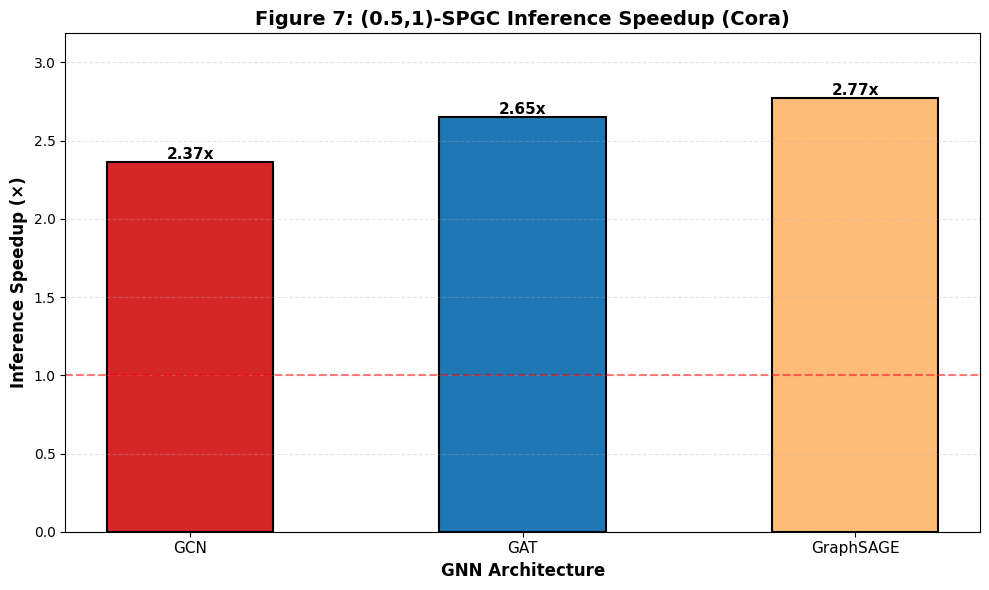


SUMMARY: (0.5,1)-SPGC INFERENCE SPEEDUP (Cora)
GNN Type        Original Time (s)    (0.5,1)-SPGC Time (s) Speedup (×)    
--------------------------------------------------------------------------------
GCN             0.029737             0.012566             2.37           x
GAT             0.270872             0.102098             2.65           x
GraphSAGE       0.061742             0.022284             2.77           x

Note: Speedup = Original Time / (0.5,1)-SPGC Time
Higher speedup values indicate better compression efficiency


In [137]:
import torch
import time
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, BatchNorm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# DEFINE GNN MODELS
# ============================================================================

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_features, 128, aggr='mean')
        self.bc1 = BatchNorm(128)
        self.conv2 = GCNConv(128, 128, aggr='mean')
        self.bc2 = BatchNorm(128)
        self.conv3 = GCNConv(128, num_classes, aggr='mean')
        self.bc3 = BatchNorm(num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.bc1(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.bc2(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.bc3(x)
        return F.log_softmax(x, dim=1)

class GAT(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = GATConv(num_features, 128, heads=8, aggr='mean')
        self.bc1 = BatchNorm(128 * 8)
        self.conv2 = GATConv(128 * 8, 128, heads=8, aggr='mean')
        self.bc2 = BatchNorm(128 * 8)
        self.conv3 = GATConv(128 * 8, num_classes, heads=1, aggr='mean')
        self.bc3 = BatchNorm(num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.bc1(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.bc2(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.bc3(x)
        return F.log_softmax(x, dim=1)

class GraphSAGE(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.conv1 = SAGEConv(num_features, 128)
        self.bc1 = BatchNorm(128)
        self.conv2 = SAGEConv(128, 128)
        self.bc2 = BatchNorm(128)
        self.conv3 = SAGEConv(128, num_classes)
        self.bc3 = BatchNorm(num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.bc1(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.bc2(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.bc3(x)
        return F.log_softmax(x, dim=1)

# ============================================================================
# INFERENCE TIMING FUNCTION
# ============================================================================

def measure_inference_time(model, data, num_runs=5):
    """Measure average inference time over multiple runs"""
    model.eval()

    # Warm-up run
    with torch.no_grad():
        _ = model(data.x, data.edge_index)

    # Measure inference time over multiple runs
    times = []
    for _ in range(num_runs):
        torch.cuda.synchronize() if torch.cuda.is_available() else None

        start_time = time.time()
        with torch.no_grad():
            _ = model(data.x, data.edge_index)
        end_time = time.time()

        times.append(end_time - start_time)

    # Return average time
    avg_time = sum(times) / len(times)
    return avg_time

# ============================================================================
# COLLECT INFERENCE TIMES AND GENERATE FIGURE 7
# ============================================================================

def collect_inference_times_and_plot(original_data=None, compressed_data=None, device='cpu'):
    """
    Create, train GNN models, measure inference times, and generate Figure 7

    Parameters:
    -----------
    original_data : torch_geometric.data.Data, optional
        Original graph. If None, will use 'cora' from globals
    compressed_data : torch_geometric.data.Data, optional
        Compressed graph. If None, will use 'datanew1' from globals
    device : str
        Device to use ('cpu' or 'cuda')
    """

    # ====== STEP 1: Get data ======
    if original_data is None:
        if 'cora' in globals():
            original_data = globals()['cora']
            print("✓ Using 'cora' from notebook globals")
        else:
            raise NameError("'cora' not found. Please ensure 'cora' is available in notebook.")

    if compressed_data is None:
        if 'datanew1' in globals():
            compressed_data = globals()['datanew1']
            print("✓ Using 'datanew1' from notebook globals")
        else:
            raise NameError("'datanew1' not found. Please ensure 'datanew1' is available in notebook.")

    original_data = original_data.to(device)
    compressed_data = compressed_data.to(device)

    num_features = original_data.x.shape[1]
    num_classes = len(torch.unique(original_data.y))

    print(f"\n✓ Original Graph: {original_data.num_nodes} nodes, {original_data.num_edges} edges")
    print(f"✓ Compressed Graph: {compressed_data.num_nodes} nodes, {compressed_data.num_edges} edges")

    # ====== STEP 2: Create models ======
    print("\n" + "="*80)
    print("STEP 1: TRAINING GNN MODELS")
    print("="*80)

    models = {
        'GCN': GCN(num_features, num_classes),
        'GAT': GAT(num_features, num_classes),
        'GraphSAGE': GraphSAGE(num_features, num_classes)
    }

    # ====== STEP 3: Train each model ======
    for gnn_name, model in models.items():
        print(f"\nTraining {gnn_name}...")
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

        # Training loop (10 epochs)
        for epoch in range(10):
            model.train()
            optimizer.zero_grad()
            out = model(original_data.x, original_data.edge_index)
            loss = F.nll_loss(out[original_data.train_mask], original_data.y[original_data.train_mask])
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 5 == 0:
                print(f"  Epoch {epoch+1}/10, Loss: {loss.item():.4f}")

        models[gnn_name] = model.cpu()

    # ====== STEP 4: Measure inference times ======
    print("\n" + "="*80)
    print("STEP 2: MEASURING INFERENCE TIMES")
    print("="*80)

    original_times = {}
    compressed_times = {}
    speedups = {}

    for gnn_name, model in models.items():
        model = model.to(device)
        model.eval()

        print(f"\n{gnn_name}:")
        print("-" * 40)

        # Measure on original graph
        orig_time = measure_inference_time(model, original_data, num_runs=5)
        original_times[gnn_name] = orig_time
        print(f"  Original Graph: {orig_time:.6f}s")

        # Measure on compressed graph
        comp_time = measure_inference_time(model, compressed_data, num_runs=5)
        compressed_times[gnn_name] = comp_time
        print(f"  (0.5,1)-SPGC:  {comp_time:.6f}s")

        # Calculate speedup
        speedup = orig_time / comp_time
        speedups[gnn_name] = speedup
        print(f"  Speedup:       {speedup:.2f}x")

    # ====== STEP 5: Generate Figure 7 ======
    print("\n" + "="*80)
    print("STEP 3: GENERATING FIGURE 7")
    print("="*80)

    gnn_types = list(speedups.keys())
    speedup_values = list(speedups.values())

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # X positions
    x = np.arange(len(gnn_types))
    width = 0.5

    # Colors: Red (GCN), Blue (GAT), Yellow (GraphSAGE)
    colors = ['#d62728', '#1f77b4', '#ffbb78']

    # Plot bars
    bars = ax.bar(x, speedup_values, width, color=colors, edgecolor='black', linewidth=1.5)

    # Add value labels on bars
    for bar, speedup in zip(bars, speedup_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               '{:.2f}x'.format(speedup),
               ha='center', va='bottom', fontsize=11, fontweight='bold')

    # Customize plot
    ax.set_xlabel('GNN Architecture', fontsize=12, fontweight='bold')
    ax.set_ylabel('Inference Speedup (×)', fontsize=12, fontweight='bold')
    ax.set_title('Figure 7: (0.5,1)-SPGC Inference Speedup (Cora)', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(gnn_types, fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_ylim(bottom=0, top=max(speedup_values) * 1.15)

    plt.tight_layout()
    plt.show()

    # ====== STEP 6: Print summary ======
    print("\n" + "="*80)
    print("SUMMARY: (0.5,1)-SPGC INFERENCE SPEEDUP (Cora)")
    print("="*80)
    print("{:<15} {:<20} {:<20} {:<15}".format('GNN Type', 'Original Time (s)', '(0.5,1)-SPGC Time (s)', 'Speedup (×)'))
    print("-"*80)

    for gnn in gnn_types:
        print("{:<15} {:<20.6f} {:<20.6f} {:<15.2f}x".format(
            gnn, original_times[gnn], compressed_times[gnn], speedups[gnn]))

    print("="*80)
    print("\nNote: Speedup = Original Time / (0.5,1)-SPGC Time")
    print("Higher speedup values indicate better compression efficiency")
    print("="*80)

    return original_times, compressed_times, speedups


# ============================================================================
# RUN THIS AT THE END OF YOUR NOTEBOOK
# ============================================================================

original_times, compressed_times, speedups = collect_inference_times_and_plot(
    original_data=cora,
    compressed_data=data_new1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)
